<a href="https://colab.research.google.com/github/gilmarschwarz/machine-learning/blob/main/yolo_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
#hide
%%writefile kaggle.json
{"username":"<username>","key":"<key>"}

Writing kaggle.json


In [4]:
#hide
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
License(s): CC0-1.0
 98% 1.20G/1.22G [00:13<00:00, 89.9MB/s]
100% 1.22G/1.22G [00:13<00:00, 93.9MB/s]


In [6]:
!mkdir hard-hat-detection

In [7]:
!unzip /content/hard-hat-detection.zip -d /content/hard-hat-detection

Streaming output truncated to the last 5000 lines.
  inflating: /content/hard-hat-detection/images/hard_hat_workers0.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers10.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers100.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1000.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1001.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1002.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1003.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1004.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1005.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1006.png  
  inflating: /content/hard-hat-detection/images/hard_hat_workers1007.png  
  inflating: /content/hard-hat-detection/images/hard_hat_w

In [8]:
import os

from google.colab import files

import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET


# Functions to convert Pascal VOC bounding boxes to YOLO format.
def xml_to_yolo_bbox(bndbox, image_size):
    # xml to yolo bounding box.
    xmin, xmax, ymin, ymax = bndbox
    # x and y mid points of the bounding box.
    x_mid = (xmin + xmax) * 0.5
    y_mid = (ymin + ymax) * 0.5
    # Height and width of the box.
    height = ymax - ymin
    width = xmax - xmin

    image_width, image_height = image_size
    image_width_inv = 1 / image_width
    image_height_inv = 1 / image_height

    x_mid = x_mid * image_width_inv
    width = width * image_width_inv
    y_mid = y_mid * image_height_inv
    height = height * image_height_inv
    return [x_mid, y_mid, width, height]


def xml_to_yolo(xml_file_path, txt_file_path, wanted_classes):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    size = root.find("size")
    img_width = int(size.find("width").text)
    img_height = int(size.find("height").text)

    output_string = ""

    for o in root.iter("object"):
        obj_class = o.find("name").text
        if obj_class in wanted_classes:
          obj_class_id = str(wanted_classes.index(obj_class))
          bndbox = o.find("bndbox")
          bndbox = [float(bndbox.find("xmin").text),
                    float(bndbox.find("xmax").text),
                    float(bndbox.find("ymin").text),
                    float(bndbox.find("ymax").text)]

          yolo_box = xml_to_yolo_bbox(bndbox, [img_width, img_height])

          output_string = output_string + obj_class_id + " "
          output_string = output_string + " ".join([str(b) for b in yolo_box])
          output_string = output_string + "\n"

    with open(txt_file_path, "w") as f:
        f.write(output_string)

In [9]:
# Prepare the obj.names, obj.data and .cfg files required for Yolov4 training.
wanted_classes = ["helmet", "head"]
image_extension = ".png"

# 1. obj.names
# This file contains the categories of all the objects in the dataset.
# The index of the category serves as its numerical category.
# Therefore class 0 is helmet and class 1 is head.
obj_names_output_string = ""
for wc in wanted_classes:
    obj_names_output_string = obj_names_output_string + wc + "\n"

with open("obj.names", "w") as f:
    f.write(obj_names_output_string)

In [13]:
!mkdir -p /content/hard-hat-detection/labels/

In [14]:
# 2. .txt annotation files.
# YOLO requires that each image file has its own .txt annotation file with the
# bounding box format:
# category x_mid_point y_mid_point width height
ann_xml_file_list = os.listdir("/content/hard-hat-detection/annotations/")
image_file_list = []

# Get all image names.
for i in os.listdir("/content/hard-hat-detection/images"):
    if i[-4:] == image_extension:
        image_file_list.append(i)

print("{} images.".format(len(image_file_list)))

# Create the .txt annotations from the .xml files.
for a in ann_xml_file_list:
    if a[-4:] == ".xml":
        file_root_name = a[:-4]
        if file_root_name + image_extension in image_file_list:
            txt_name = file_root_name + ".txt"
            xml_to_yolo(os.path.join("/content/hard-hat-detection/annotations/", a),
                        os.path.join("/content/hard-hat-detection/labels/", txt_name),
                        wanted_classes)

5000 images.


In [12]:
!mkdir -p /content/hard-hat-detection/train/labels
!mkdir -p /content/hard-hat-detection/train/images
!mkdir -p /content/hard-hat-detection/test/labels
!mkdir -p /content/hard-hat-detection/test/images

In [ ]:
#!rm -rf /content/hard-hat-detection/train

In [15]:
import os
import shutil
for filename in sorted(os.listdir("/content/hard-hat-detection/labels"))[-1000:]:
    filename_relPath = os.path.join("/content/hard-hat-detection/labels",filename)
    shutil.copy(filename_relPath,"/content/hard-hat-detection/train/labels")

for filename in sorted(os.listdir("/content/hard-hat-detection/images"))[-1000:]:
    filename_relPath = os.path.join("/content/hard-hat-detection/images",filename)
    shutil.copy(filename_relPath,"/content/hard-hat-detection/train/images")

for filename in sorted(os.listdir("/content/hard-hat-detection/labels"))[:200]:
    filename_relPath = os.path.join("/content/hard-hat-detection/labels",filename)
    shutil.copy(filename_relPath,"/content/hard-hat-detection/test/labels")

for filename in sorted(os.listdir("/content/hard-hat-detection/images"))[:200]:
    filename_relPath = os.path.join("/content/hard-hat-detection/images",filename)
    shutil.copy(filename_relPath,"/content/hard-hat-detection/test/images")


In [16]:
lst = os.listdir("/content/hard-hat-detection/train/labels")
len(lst)

1000

In [17]:
root_dir="/content/hard-hat-detection"
train_imgs_dir="/content/hard-hat-detection/train/images"
valid_imgs_dir="/content/hard-hat-detection/test/images"
test_imgs_dir="/content/hard-hat-detection/test/images"

In [18]:
train_labels_dir="/content/hard-hat-detection/train/labels"
valid_labels_dir="/content/hard-hat-detection/test/labels"
test_labels_dir="/content/hard-hat-detection/test/labels"

In [19]:
names={0:"helmet",1:"head"}
COLORS=np.random.uniform(0,255,(2,1))

In [20]:
def show_bbox(img_name,img_dir,label_dir,axis):
    img_path=os.path.join(img_dir,img_name)
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,_=img.shape
    img=img.copy()

    try:
        label_path=os.path.join(label_dir,img_name[:-4]+".txt")
        label=pd.read_csv(label_path,sep=" ",header=None).values
        classes=label[:,0]
        boxes=label[:,1:]

        for i,box in enumerate(boxes):
            cls_id=int(classes[i])
            text=names[cls_id]
            color=COLORS[cls_id]
            xmin=int((box[0]-box[2]/2)*w)
            ymin=int((box[1]-box[3]/2)*h)
            xmax=int((box[0]+box[2]/2)*w)
            ymax=int((box[1]+box[3]/2)*h)
            cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color,3)
            y=ymin-10 if ymin-10>10 else ymin+20
            cv2.putText(img,text,(xmin,y),cv2.FONT_HERSHEY_SIMPLEX,1.5,color,3)
    except:
        pass

    axis.imshow(img)
    axis.axis("off")

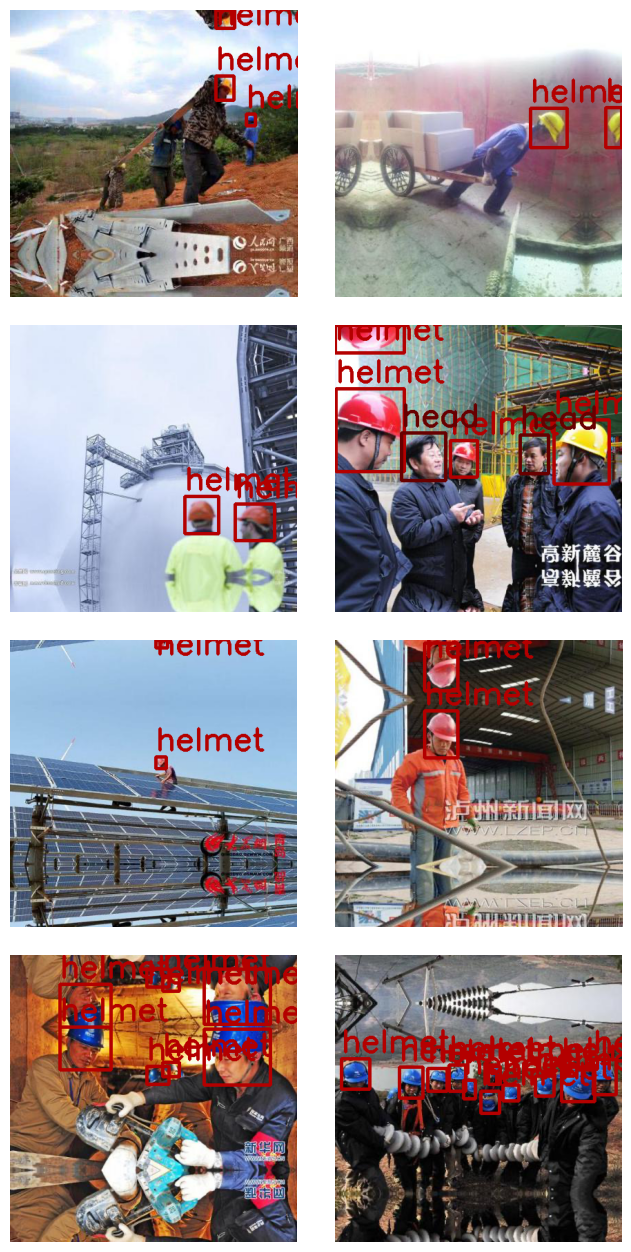

In [39]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()


train_img_list=sorted(os.listdir(train_imgs_dir))
img_name_list=np.random.choice(train_img_list,8)


for i,img_name in enumerate(img_name_list):
    show_bbox(img_name,train_imgs_dir,train_labels_dir,ax[i])

plt.savefig("1.png")

In [22]:
yolo_format=dict(path=root_dir,
                 train=train_imgs_dir,
                 val=valid_imgs_dir,
                 nc=2,
                 names=names)

with open('yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [24]:
model=YOLO('yolov8l.pt')
model.train(data="yolo.yaml",epochs=10,patience=20,batch=8,
            lr0=0.0003,imgsz=224,freeze=6)

Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=yolo.yaml, epochs=10, time=None, patience=20, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=6, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, 

train: Scanning /content/hard-hat-detection/train/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/hard-hat-detection/test/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       1.65      1.353      1.108         40        224: 100%|██████████| 125/125 [20:12<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:10<00:00, 10.07s/it]

                   all        200        956      0.315      0.587       0.36      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.502     0.9505      1.047         38        224: 100%|██████████| 125/125 [20:03<00:00,  9.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:07<00:00,  9.78s/it]

                   all        200        956      0.762      0.588      0.658      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.519     0.9062      1.049         37        224: 100%|██████████| 125/125 [20:05<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:06<00:00,  9.70s/it]

                   all        200        956      0.819      0.642      0.713      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.483      0.833      1.021         39        224: 100%|██████████| 125/125 [20:05<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:05<00:00,  9.68s/it]

                   all        200        956      0.852      0.637      0.742      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.423      0.789      1.012         32        224: 100%|██████████| 125/125 [20:00<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:05<00:00,  9.62s/it]

                   all        200        956      0.875      0.716      0.826      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.402     0.7672       1.01         33        224: 100%|██████████| 125/125 [20:05<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:06<00:00,  9.74s/it]

                   all        200        956      0.865       0.75      0.822      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.352     0.7314     0.9873         55        224: 100%|██████████| 125/125 [20:16<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:06<00:00,  9.73s/it]

                   all        200        956      0.871      0.763      0.837      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G       1.29     0.6677     0.9861         39        224: 100%|██████████| 125/125 [20:14<00:00,  9.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:07<00:00,  9.78s/it]

                   all        200        956      0.882      0.758      0.839        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.262     0.6588     0.9634         45        224: 100%|██████████| 125/125 [20:12<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:05<00:00,  9.67s/it]

                   all        200        956      0.874       0.77      0.844      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.242      0.635     0.9577         47        224: 100%|██████████| 125/125 [20:11<00:00,  9.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:05<00:00,  9.68s/it]

                   all        200        956      0.891      0.768      0.856       0.53



10 epochs completed in 3.748 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 87.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 112 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:08<00:00,  9.86s/it]


                   all        200        956      0.896      0.767      0.856       0.53
                helmet        176        694      0.918      0.779      0.887      0.558
                  head         45        262      0.874      0.756      0.824      0.503
Speed: 0.4ms preprocess, 622.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78cdbb05a150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [25]:
path_best_weights="/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)

metrics = model.val(conf=0.20,iou=0.70)

Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 112 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/hard-hat-detection/test/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:00<00:00,  9.26s/it]


                   all        200        956      0.632       0.37      0.542      0.313
                helmet        176        694      0.517      0.493      0.581      0.335
                  head         45        262      0.747      0.248      0.503      0.291
Speed: 0.3ms preprocess, 584.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val


In [26]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.20,iou=0.70)


image 1/200 /content/hard-hat-detection/test/images/hard_hat_workers0.png: 224x224 10 helmets, 5 heads, 539.7ms
image 2/200 /content/hard-hat-detection/test/images/hard_hat_workers1.png: 224x224 10 helmets, 513.4ms
image 3/200 /content/hard-hat-detection/test/images/hard_hat_workers10.png: 224x224 (no detections), 554.3ms
image 4/200 /content/hard-hat-detection/test/images/hard_hat_workers100.png: 224x224 (no detections), 484.4ms
image 5/200 /content/hard-hat-detection/test/images/hard_hat_workers1000.png: 224x224 3 helmets, 531.9ms
image 6/200 /content/hard-hat-detection/test/images/hard_hat_workers1001.png: 224x224 4 helmets, 516.0ms
image 7/200 /content/hard-hat-detection/test/images/hard_hat_workers1002.png: 224x224 4 helmets, 529.6ms
image 8/200 /content/hard-hat-detection/test/images/hard_hat_workers1003.png: 224x224 (no detections), 512.9ms
image 9/200 /content/hard-hat-detection/test/images/hard_hat_workers1004.png: 224x224 8 helmets, 508.6ms
image 10/200 /content/hard-hat-det

In [27]:
# directory for saving predictions on test dataset
!mkdir "prediction_yolo8vl"

In [28]:
prediction_dir="/content/prediction_yolo8vl"

In [29]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xywhn.cpu().numpy()
        classes=result.boxes.cls.cpu().numpy()

        test_img_list.append(name)

        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for cls_obj,box in zip(classes,boxes):
                text=f"{int(cls_obj)} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

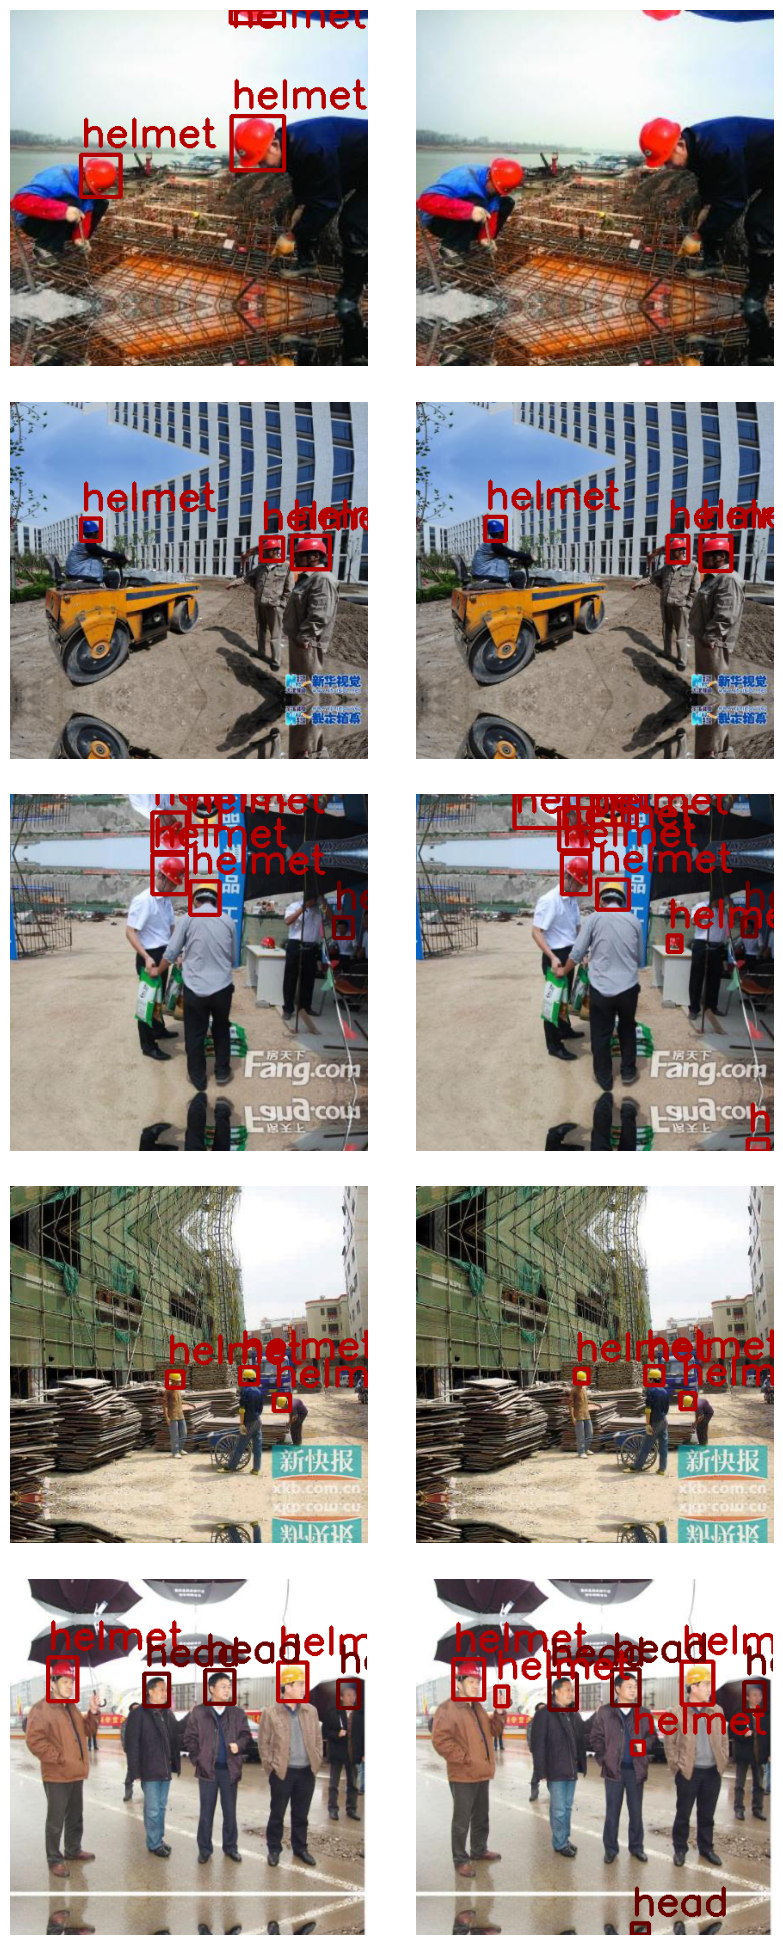

In [37]:
fig,axes=plt.subplots(5,2,figsize=(10,25))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

test_img_list=list(sorted(os.listdir(test_imgs_dir)))
imgs_name=np.random.choice(test_img_list,5)

for i,img_name in enumerate(imgs_name):
    #ground truth
    show_bbox(img_name,test_imgs_dir,test_labels_dir,axis=axes[i,0])

    #predicted label
    show_bbox(img_name,test_imgs_dir,prediction_dir,axis=axes[i,1])

plt.savefig("2.png")